### Exercise 3. Unconfined flow in an earth dam

The goal of this exercise is to understand how to calculate an unconfined flow in an earth dam using a relative permeability.

For the solution we use a fixed point iterations scheme with under-relaxation.

In [3]:
# importing the necessary python modules
# numpy and matplotlib are popular packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt

# scipy is an extension for numpy, used extensively in scientific computing
import scipy as sp

# interactive python (iPython) magic to instruct jupyter how to show the plots with respect to the code cells
%matplotlib inline

# various plotting parameters
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = 12

import pygmsh

# here we import the functions translated from matlab
# to do so, we need to change the relative path
import sys
sys.path.append('../src')

# And we import the necessary tools from our source folder.
from MesherWrapper import Mesh
#import Elements
from MeshUtils import MeshUtils
#import MatrixAssembly
import PoroElasticProperties as prop

First, let's build the geometry of the dam according to the figure below.

<font size = "6"> Important! </font> When creating a geometry, nodes have to be ordered counter-clockwise to avoid negative elementary jacobians later in the FEM assembly.
# ![sizes](figure_1.png)

Text(0, 0.5, 'y (m)')

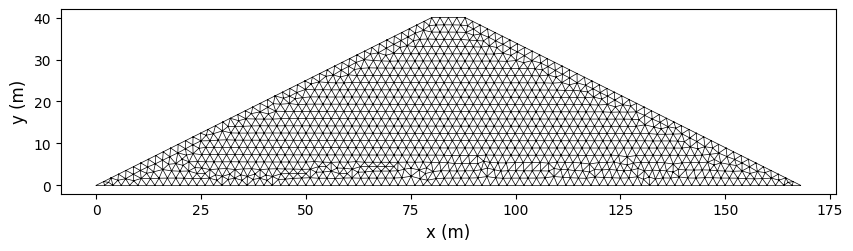

In [3]:
# geometry
b = 8
hd = 40
hw = 35
m = 2 # slope of the upstream wall
m1 = 2 # slope of the downstream wall

# define the dam vertices coordinates
# the origin of the coordinate system is on the bottom-left corner
xtl = m * hd  # crest left x
xtr = xtl + b  # crest right x
x_ext = xtr + m1 * hd  # toe dam x

vertices = np.array([[0, 0],
                     [x_ext, 0],
                     [xtr, hd],
                     [xtl, hd]])

# we can have a per point cell resolution, telling pygmsh where we want finer elements
# resolutions = np.array([5, 5, 5, 5,])
resolutions = np.array([2, 2, 2, 2,])
#resolutions = np.array([10., 0.5, 0.5, 0.5,])

with pygmsh.geo.Geometry() as geom:
    # we initiate an empty line list
    lines = []

    # we instantiate points p1 and p2 and make sure to store the first one in p0
    p1 = p0 = geom.add_point(vertices[0], resolutions[0])

    # at every iteration, we make a line going from p1 to p2
    for k in range(len(vertices) - 1):
        p2 = geom.add_point(vertices[k + 1], resolutions[k + 1])
        line = geom.add_line(p1, p2)
        lines.append(line)
        p1 = p2  # we make sure that p1 becomes p2, the next point to be in lines

    # we add the last line, closing the loop with p2 to p0
    lines.append(geom.add_line(p2, p0))

    # curve loop is a collection of lines where every endpoints are connected
    loop = geom.add_curve_loop(lines)  

    # the plane surface is the area that is going to be partitionned in finite elements
    surf = geom.add_plane_surface(loop)

    # final command to do the computations
    out = geom.generate_mesh()

# we pass it to our wrapper object 'Mesh' with which we'll be interacting through our computations
mesh = Mesh(out)

# as permeability of each element will change independently we will assign matIDs correspondingly
mesh.id = range(mesh.number_els)

# we can use the mesh.plot() function to easily show it
fig, ax = mesh.plot()
fig.set_size_inches(10, 5)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

In [ ]:
# find the nodes belonging to each boundary
# complete the code below:
# left = 
# left_sat = 
# left_unsat = 
# right = 
# bottom = 
# top = 


mesh.plot()
for boundary in [left_unsat, left_sat, right, bottom, top]:
    plt.scatter(*mesh.nodes[boundary].T, alpha=1)


We now combine all nodes where we are either sure or do no know yet if they are unsaturated. This is the combination of the nodes above water
level on the left / upstream side (unsaturated), the ones on top (unsaturated), and the nodes on the right / downstream side. The nodes on the right side can be saturated or not (depending on where the water level passes in the earth dam).

In [ ]:
# combine all the unsaturated nodes and get rid of duplicates
nodes_unsat = np.unique(np.hstack((left_unsat, top, right)))
mesh.plot()
plt.scatter(*mesh.nodes[nodes_unsat].T)

### Defining a relative permeability

Here we define a function computing relative permeability as a function of water head and a regularization parameter. There are different equations available in the literature. We will use $\tanh(x)$ as a base. We will define our relative permability function as 

$$ k_{rel} = 0.5 \left(1 + \tanh\left(\frac{p}{p*}\right)\right) + \epsilon_M, $$

where $p$ is the pressure at a given node, $p*$ defines the *sharpness* of the relative permeability function and $\epsilon_M$ is a very small number (to omit null permeability). Since our permeability is defined for every element and the pressure is defined at the nodes, we will compute the average pressure at a given element to compute the relative permeability. 

In [ ]:
def element_relative_permeability(p, p_star, epsilon_m):
    # complete the code below:
    # k_rel = 
    return k_rel   

def mesh_relative_permeability(mesh, p, p_star, epsilon_m = 1e-10):
    k_rel = np.ones(mesh.number_els)
    p_mean = np.ones(mesh.number_els)

    for el in range(mesh.number_els):
        
        n_e = mesh.connectivity[el]

        # average pressure within an element
        # complete the code below:
        # p_mean[el] = 

        k_rel[el] = element_relative_permeability(p_mean[el], p_star, epsilon_m)
    
    return k_rel, p_mean


# let us test the effect of differente pressures and eps values on the relative permeability curves
gammaw = 10     # weight of water [Pa / m]
# pressure range from negative to positive
p = np.geomspace(1e-1, hd * gammaw, 50)
p = np.hstack((-p[::-1], p))
# three values of smoothening parameter
ch_pressure = [1e-2, 1e0, 10]

for p_star in ch_pressure:
    y = element_relative_permeability(p/10, p_star, 1e-10) 
    plt.plot(p, y, label=f'10$^{{{np.log10(p_star):.0f}}}$', alpha=1.0)

plt.xlabel('p (Pa)')
plt.ylabel('$k_r$ [-]')
plt.legend(title=r'$p*$')
plt.xlim(p.min(), p.max())


Below we will employ the fixed-point iteration scheme to compute the piezometric head

In [ ]:
# we initialize a pressure vector
heads = np.zeros(mesh.number_nodes)

# pressure is equal to the water table where it is saturated
heads[left_sat] = hw

# on the unsaturated boundary we will apply zero flux (natural Neumann)
# boundary conditions as the initial guess (applied naturally)

# we define two sets of nodes: impervious boundary (flux = 0) and outflow boundary (flux < 0)
nodes_no_flux = nodes_unsat.copy()
nodes_outflow = np.array([], dtype=int)

# we define a vector with absolute hydraulic conductivity which will be updated based on saturation conditions
k_0 = 1. # hydraulic conductivity of material [L/s]
k_current = k_0 * np.ones(mesh.number_els) # [L/s]

# some parameters related to the solution
beta       = 0.9    # underrelaxation coefficient (1 if none)
p_star     = 0.1     # sharpness of the relative permeability function (in Pa )
min_kr     = 1e-4    # minimum value of the relative perm
tol        = 1e-5    # relative tolerance on the solution increment for the iterative scheme
a_tol      = 1.e-5   # absolute tolerance for checking >0. -> > a_tol
iter_max   = 20      # maximum number of iterations for the fixed point scheme
k          = 0       # iteration count

error = 1
errors = []

# define the nodes where the boundary conditions are definite (underwater part of the upstream wall)
nodes_fixed = left_sat.copy()

while (k < iter_max) and (error > tol):

    # We assemble the conductivity matrix with the current permeability
    # complete the code below:
    # C = 

    # First, we have to separate the nodes where the piezometric head is
    # unknown from nodes where the piezometric head is fixed (because of 
    # the boundary conditions).   
    eq_to_solve = np.setdiff1d(np.arange(mesh.number_nodes), nodes_fixed)    

    # Compute the force vector
    f = -C[eq_to_solve][:, nodes_fixed].dot(heads[nodes_fixed])
    
    # Compute the unknown piezometric heads at each step by solving the system C h = f
    # complete the code below:
    # h_i = sp.sparse.linalg.solve(...)

    # Updating the global vector of unknowns
    heads_prev = heads.copy()
    heads[eq_to_solve] = h_i

    # we relax the solution at the current step
    heads = (1 - beta) * heads_prev + beta * heads

    # Compute the new relative permeability of each element
    pressure = gammaw * (heads - mesh.nodes[:, 1])    
    # complete the code below:
    # k_rel, _ = 
    k_current = k_0 * k_rel

    nodal_fluxes = C.dot(heads)
    old_nodes_outflow = nodes_outflow.copy()
    old_nodes_no_flux = nodes_no_flux.copy()

    # Condition 1: current impervious boundary nodes that exhibit a head larger than elevation 
    # must become fixed pressure nodes  - we use a tolerance a_tol here 
    bools_cond_1 = heads[old_nodes_no_flux] - mesh.nodes[old_nodes_no_flux, 1] > a_tol
    indices_cond_1 = np.argwhere(bools_cond_1)[:,0]

    # Condition 2: current outflow nodes which have an "inflow" must become impervious boundary nodes
    # inflow is akin to positive nodal_fluxes -  we use a tolerance a_tol here 
    bools_cond_2 = nodal_fluxes[old_nodes_outflow] > a_tol
    indices_cond_2 = np.argwhere(bools_cond_2)[:,0]

    # remove the nodes of the second list from the nodes_outflow (removal MUST be done first)
    nodes_outflow = np.delete(old_nodes_outflow, indices_cond_2)
    # add nodes from the first list to the nodes_outflow
    nodes_outflow = np.unique(np.hstack((nodes_outflow, old_nodes_no_flux[indices_cond_1])))
    # remove nodes from the first list to the nodes_outflow (removal MUST be done first)
    nodes_no_flux = np.delete(old_nodes_no_flux, indices_cond_1)
    # add nodes from the second list to the the nodes_no_flux
    nodes_no_flux = np.unique(np.hstack((nodes_no_flux, old_nodes_outflow[indices_cond_2])))    

    assert nodes_outflow.size + nodes_no_flux.size == nodes_unsat.size, f"iter {k} sum of no-flux and zero-pressure nodes is not equal to nodes_unsat"

    # re enforce boundary conditions 
    # nodes_fixed = np.hstack((left_sat, nodes_unsat[i_fixed]))
    nodes_fixed = np.hstack((left_sat, nodes_outflow))
    heads[left_sat] = hw
    # fix pressures of the outflow nodes to zero (or head to their y coordinates)
    # complete the code below:
    #heads[...] =
    
    # Compute the error of the current step by comparing the solution of 
    # the hydraulic head to the one of the previous step.
    error = np.nanmedian(np.abs((heads - heads_prev)/heads))
    errors.append(error)
    print(f'\riteration {k+1} out of {iter_max}, {nodes_outflow.size} zero-p nodes, {nodes_no_flux.size} no-flux nodes, rel change = {  error:.6f} ')

    k += 1

# plot the convergence rate
plt.plot(np.arange(k) + 1, np.array(errors) , marker='.')
plt.yscale('log')
plt.xlabel('Iteration #')
plt.ylabel('Relative change in h [-]')


Plotting solution on the mesh.

In [ ]:
# plot the nodes fixed within the last iteration
fig, _ = mesh.plot()
fig.set_size_inches(15, 15)
plt.scatter(*mesh.nodes[nodes_outflow].T)
plt.scatter(*mesh.nodes[nodes_no_flux].T)

# hydraulic conductivity
fig, ax, cb = mesh.plot(k_current, shading='flat')
xlim = ax.get_xlim()
ax.fill_between((xlim[0], mesh.nodes[:, 0].max()/2), hw, 0, zorder=0, ec='tab:blue', alpha=0.3)
ax.set_xlim(xlim)
ax.set_ylim(0, None)
fig.set_size_inches(15, 15)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
cb.ax.set_ylabel('$k_r$')

# hydraulic heads
fig, ax, cb = mesh.plot(heads, shading='gouraud')
xlim = ax.get_xlim()
ax.fill_between((xlim[0], mesh.nodes[:, 0].max()/2), hw, 0, zorder=0, ec='tab:blue', alpha=0.3)
ax.set_xlim(xlim)
ax.set_ylim(0, None)
fig.set_size_inches(15, 15)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
cb.ax.set_ylabel('Water heads [m]')

Now we will compute averaged per element fluxes and plot them at the barycenter positions. For this you have to complete function `compute_element_flux` of `Triangle` class in Elements.py module.

In [ ]:
# Calculate the fluxes averaged per element
Q_av=np.zeros((mesh.number_els,mesh.dim))
barycenters = np.zeros((mesh.number_els,mesh.dim))

pressure =  gammaw * (heads - mesh.nodes[:, 1])    
k_rel, _ = mesh_relative_permeability(mesh, pressure, p_star, epsilon_m=1.e-5)

# loop over all the element
for el in range(mesh.number_els):
    
    # get nodes of element el
    nodes_el = mesh.connectivity[el]
 
    # corresponds coordinates
    coor = mesh.nodes[nodes_el]
    barycenters[el]= MeshUtils.getBarycenter(mesh, el)
    
    # create Element object
    element = Elements.Triangle(coor, 'linear', '2D')
    
    # corresponding local solution - scalar dof mapping
    usol = heads[nodes_el]
    elt_cond = k_rel[el]
    qel=element.compute_element_flux(elt_cond,usol)
    Q_av[el]=qel

fig, ax, cb = mesh.plot(pressure, shading='flat')

# label the axes and the color code
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
cb.ax.set_title('Pressure (Pa)')
fig.set_size_inches(15, 15)

# And add the fluxes as arrows at the barycenters positions
# complete the code below:
# ax.quiver(...)

Below, we will compute the analytical solution by Pavlovsky presented by the figure and equation below.
# ![sizes](figure_2.png)

This solution is obtained through the following system of two nonlinear equations (valid for the case $h_{0}=0$) that can be solved both graphically or iteratively, for instance, by fixed point iterations. For the latter, we eliminate one of the unknowns ($a_0$ or $h$) by substituting one equation into another and solve the resulting nonlinear equation.

$a_{0}=\frac{b}{m_{1}}+h_{d}-\sqrt{\left(\frac{b}{m_{1}}+h_{d}\right)^{2}-h^{2}}$

$a_{0}=\frac{m_1}{m}\left(h_{w}-h\right)\ln\left(\frac{h_{d}}{h_{d}-h}\right)$

In the above equations, $h$ is the possible value of the water head within the dam, which can take the maximum value of the crest elevation $h_d$.

How does the analytical solution relates with the numerical one?

In [ ]:
# Graphical solution
h_axes=np.linspace(0, hd, 100)
# complete the code below:
# a0_1 = 
# a0_2 =

plt.plot(h_axes, a0_1, label='$a_{01}$' )
plt.plot(h_axes, a0_2, label='$a_{02}$' )
plt.grid(True)
plt.xlabel('h [m]')
plt.ylabel('$a_0$ [m]')


# Fixed point solution
tolerance = 1.e-10
iter_max=10
k=0
h=0.6*hw
err=1
while (k < iter_max) & (err > tolerance):
    k = k+1
    h0 = h
    # below we write the resulting expression for the head h while keeping the unknown h in the nonlinear operators (square root and logarith) approximated through h0
    # complete the code below:
    # h = 
    err = np.abs((h - h0) / h)
    print(f'step number {k}, error = {err}')

a0 = m1 / m * (hw - h) * np.log(hd / (hd - h))
print(f'h = {h}, and a0 = {a0}')